© [Mariia Seleznova](https://www.ai.math.uni-muenchen.de/members/postdocs/mariia-seleznova/index.html), 2025. [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).

# 🌳 Decision Trees

This notebook introduces a new type of machine learning model: **decision trees**. A decision tree is a flowchart-like structure where each internal node makes a binary decision, splitting the dataset based on some feature and threshold. The tree branches recursively until it reaches a leaf, which gives a prediction.

Unlike all the previous models we've studied, decision trees are **not trained with gradient descent**. Instead, they are built **greedily** by recursively selecting the best feature and split point according to a chosen criterion (e.g. Gini impurity or information gain).

<img src="images/tree.png" alt="Decision tree diagram" width="900"/>


## ⚙️ Implementation 

A decision tree **recursively** splits the input dataset based on feature values. At each internal node, it selects the **feature and threshold that best separate the data** according to a certain criterion. The process continues until stopping criteria are met (e.g., max depth or pure class labels). **Leaves** of the tree assign the final class.

To implement decision trees, we must decide:

1. **How to split the data?** \
  We use **Gini impurity** to evaluate how "pure" a split is (defined below).
   
2. **When to stop splitting?** \
  We stop and make a leaf if any of the following stopping criteria hold:
    - Max depth is reached
    - All labels are the same
    - The split contains too few samples
   
3. **How to make a prediction on a new input?** \
  Leaves return the **most common class label** among the training examples they contain.

> 🔎 **Note:** In this class, we only implement **classification trees** and use **Gini impurity**. In practice, other criteria like entropy or mean squared error (for regression) can be used.


### 🧱 Class Structure

- `DecisionTreeNode`: represents a single node in the tree.
  - If `value` is not `None`, the node is a **leaf** and predicts a class.
  - Otherwise, the node stores a `feature` and `threshold` to split on and has two children: `left` and `right`.
  - The children (`left` and `right`) are themselves `DecisionTreeNode` instances. Thus, from each node we can navigate to its children.

- `DecisionTreeClassifier`: builds the full tree using recursive splitting.

### 🔄 Training — `fit()`

1. The training method is `fit(X, y)`, which calls `_build_tree()` starting at depth 0 (root node).
2. The tree grows recursively by choosing the **best split** at each node.

### 🌲 Tree Construction — `_build_tree(X, y, depth)`

`_build_tree` for a given node is called recursively by its parent node. At each node, this method does the following:
- Return a **leaf node** with the most common label if **stopping conditions** are reached:
  - Reached `max_depth` (maximal allowed tree depth)
  - Node is pure (labels contain only one class)
  - Not enough samples to split (fewer than `min_samples_split` elements in the split)
- Otherwise:
  1. Call `_best_split()` to find the feature and threshold that give the best **Gini impurity** (see below).
  2. Partition the dataset based on the split.
  3. Recursively build the left and right subtrees (call `_build_tree` on both part of the dataset).


### ✂️ Finding the Best Split — `_best_split(X, y)`

- For each feature:
  - Try all unique values as potential thresholds.
  - Split the dataset into `left` and `right` parts.
  - Compute the **Gini impurity** for the split.
- Keep track of the feature/threshold with the **lowest** impurity.


### 📉 Gini Impurity — `_gini_index(left, right)`

Gini impurity measures how "mixed" a node is. A pure node (only one class) has `Gini = 0`.  
For each split:

$$
\text{Gini}(S) = 1 - \sum_c p(c)^2
$$

Weighted average over left/right subsets is used to evaluate the quality of a split.


### 🔍 Prediction

To classify a new sample:
- Start at the root node
- Follow left/right branches based on comparisons (`x[feature] < threshold`)
- When a leaf is reached, return its label

### ✅ Summary

This is a **greedy**, top-down algorithm:
- At each node, the algorithm picks the best split **locally**, without considering future consequences (no global optimization).
- It builds the tree recursively until stopping conditions are met.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
import os

# Add the repo root (two levels up from this notebook) to sys.path
sys.path.insert(0, os.path.abspath("../../"))

In [2]:
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature        # index of the feature to split on
        self.threshold = threshold    # threshold value for split
        self.left = left              # left subtree
        self.right = right            # right subtree
        self.value = value            # value for leaf node (class)

    def is_leaf(self):
        return self.value is not None

class DecisionTreeClassifier():
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y, depth=0)
        return None  # metrics tracking skipped

    def __call__(self, X):
        # Reshape to (N, D) if X is higher-dimensional
        if X.ndim > 2:
            original_shape = X.shape[:-1]
            X_flat = X.reshape(-1, X.shape[-1])
            preds = np.array([self._predict(x, self.root) for x in X_flat])
            return preds.reshape(original_shape)
        else:
            return np.array([self._predict(x, self.root) for x in X])
        
    def _predict(self, x, node):
        while not node.is_leaf():
            if x[node.feature] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value

    def _build_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        if (depth >= self.max_depth or
            num_labels == 1 or
            num_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return DecisionTreeNode(value=leaf_value)

        # Find best split
        best_feat, best_thresh = self._best_split(X, y, num_features)
        if best_feat is None:
            return DecisionTreeNode(value=self._most_common_label(y))

        # Split dataset
        left_idx = X[:, best_feat] < best_thresh
        right_idx = ~left_idx
        left = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._build_tree(X[right_idx], y[right_idx], depth + 1)
        return DecisionTreeNode(feature=best_feat, threshold=best_thresh, left=left, right=right)

    def _best_split(self, X, y, num_features):
        best_gini = float('inf')
        best_feat, best_thresh = None, None

        for feature_idx in range(num_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_idx = X[:, feature_idx] < threshold
                right_idx = ~left_idx
                if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                    continue
                gini = self._gini_index(y[left_idx], y[right_idx])
                if gini < best_gini:
                    best_gini = gini
                    best_feat = feature_idx
                    best_thresh = threshold

        return best_feat, best_thresh

    def _gini_index(self, left, right):
        def gini(y):
            classes = np.unique(y)
            return 1.0 - sum((np.sum(y == cls) / len(y)) ** 2 for cls in classes)

        total = len(left) + len(right)
        return (len(left) / total) * gini(left) + (len(right) / total) * gini(right)

    def _most_common_label(self, y):
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]


# 🌸 Test on the Iris Dataset

In [3]:
from courselib.utils.loaders import load_irises 
from courselib.utils.splits import train_test_split

df = load_irises()

X, Y, X_train, Y_train, X_test, Y_test =  train_test_split(df[['sepal length [cm]', 'petal width [cm]', 'iris type']], 
                                          training_data_fraction=0.8,
                                          return_numpy=True,
                                          class_column_name='iris type')

def labels_to_numbers(labels, class_names=None):
    if class_names is None:
        class_names = np.unique(labels)
    label_to_number = {label: i for i, label in enumerate(class_names)}
    return np.array([label_to_number[label] for label in labels])

class_names = np.unique(Y)
Y, Y_train, Y_test = labels_to_numbers(Y, class_names), labels_to_numbers(Y_train, class_names), labels_to_numbers(Y_test, class_names)

Loading from local `iris_data_set.csv`...


### Train and Evaluate

In [ ]:
from courselib.utils.metrics import accuracy

model = DecisionTreeClassifier(max_depth=5, min_samples_split=2)
model.fit(X_train, Y_train)

test_acc = accuracy(model(X_test), Y_test, one_hot_encoded_labels=False)
train_acc = accuracy(model(X_train), Y_train, one_hot_encoded_labels=False)

print(f"✅ Train Accuracy: {train_acc:.4f}")
print(f"🧪 Test Accuracy:  {test_acc:.4f}")


✅ Train Accuracy: 98.3333
🧪 Test Accuracy:  90.0000


## Visualize Results 

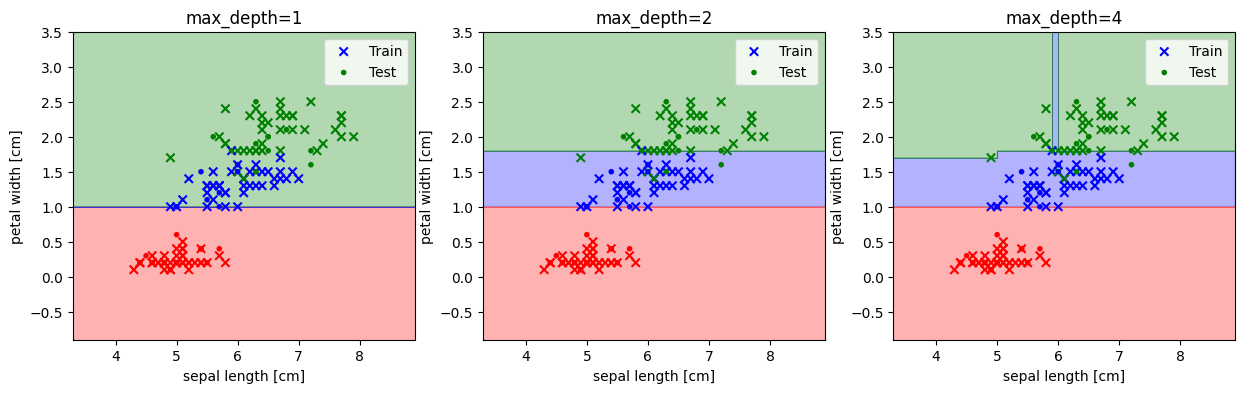

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15, 4))

x1_min = X_train[:, 0].min() - 1
x1_max = X_train[:, 0].max() + 1
x2_min = X_train[:, 1].min() - 1
x2_max = X_train[:, 1].max() + 1

x1_list, x2_list = np.meshgrid(np.arange(x1_min, x1_max, .01), 
                               np.arange(x2_min, x2_max, .01))

X_list = np.dstack([x1_list, x2_list])

for _ax, max_depth in zip(ax, [1,2,4]):

    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=1)
    model.fit(X_train, Y_train) 

    h_list = model(X_list)

    cmap = matplotlib.colors.ListedColormap(['red', 'blue', 'green'])
    _ax.contourf(x1_list, x2_list, h_list, cmap=cmap, alpha=.3)

    _ax.scatter(X_train[:, 0], X_train[:, 1], marker='x', 
                color=[cmap.colors[y] for y in Y_train], label='Train')

    _ax.scatter(X_test[:, 0], X_test[:, 1], marker='.', 
                color=[cmap.colors[y] for y in Y_test], label='Test')

    _ax.set_title(f'max_depth={max_depth}')
    _ax.set_xlabel('sepal length [cm]')
    _ax.set_ylabel('petal width [cm]')
    _ax.set_xlim(x1_min, x1_max)
    _ax.set_ylim(x2_min, x2_max)
    _ax.legend()

## 🔠 Test on Letter Recognition Dataset

To better understand the behavior of decision trees, we now evaluate them on the larger and more challenging **Letter Recognition** dataset (previously used in class).

Unlike the Iris dataset, where even shallow trees perform well due to its simplicity, this dataset allows us to examine how tree **depth** affects performance.


In [ ]:
from courselib.utils.loaders import load_digits

df = load_digits()

X, Y, X_train, Y_train, X_test, Y_test = train_test_split(df, 0.8, return_numpy=True, class_column_name='letter')
class_names = np.unique(Y)
Y = labels_to_numbers(Y, class_names)
Y_train = labels_to_numbers(Y_train, class_names)
Y_test = labels_to_numbers(Y_test, class_names)

Loading from local `letter-recognition.data`...


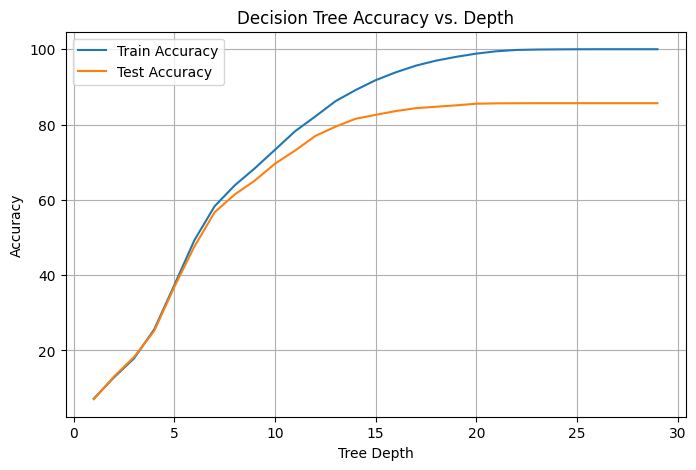

In [7]:
test_accuracy_scores = []
train_accuracy_scores = []
depths = range(1, 30)

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, min_samples_split=2)
    model.fit(X_train, Y_train)

    train_acc = accuracy(model(X_train), Y_train, one_hot_encoded_labels=False)
    test_acc = accuracy(model(X_test), Y_test, one_hot_encoded_labels=False)

    train_accuracy_scores.append(train_acc)
    test_accuracy_scores.append(test_acc)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(depths, train_accuracy_scores, label='Train Accuracy')
plt.plot(depths, test_accuracy_scores, label='Test Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs. Depth')
plt.legend()
plt.grid(True)
plt.show()


From the depth vs. accuracy plot, we can observe the following:

- ✅ **Accuracy improves with depth**: As the tree depth increases, both train and test accuracy improve — up to a point — after which test accuracy **plateaus**.
  
- 🧠 **Stronger than softmax regression**: Deep trees outperform softmax regression, showing their higher capacity for complex decision boundaries.

- ⚠️ **Signs of mild overfitting**: At high depths, training accuracy reaches 100%, while test accuracy levels off below that. Although test accuracy does **not decrease**, the growing gap between train and test accuracy suggests **overfitting in the form of memorization without full generalization**.

## 📉 Sensitivity to Data

Although decision trees fit the dataset well, they are highly sensitive to small changes in the training data. Even slight variations in the train/test split can lead to a completely different tree structure and drastically different decision boundaries.

To investigate how **unstable** decision trees are with respect to small changes in the training data, we run the following experiment:

- For 10 iterations:
  - We randomly sample **80% of the training data** (without replacement).
  - We train a **decision tree** on each sampled subset.
  - We evaluate the trained tree on the **full test set**, storing its predictions.

- After collecting predictions from all 10 trees:
  - For each test sample, we compute the **majority vote** among the 10 predictions.
  - We then calculate the **fraction of trees that disagree** with the majority vote — a per-sample measure of **disagreement**.

This allows us to visualize how much **prediction variability** is caused by changes in training data — a key characteristic of **high-variance models** like decision trees.

100%|██████████| 10/10 [02:34<00:00, 15.43s/it]


Average disagreement across all samples: 0.3942


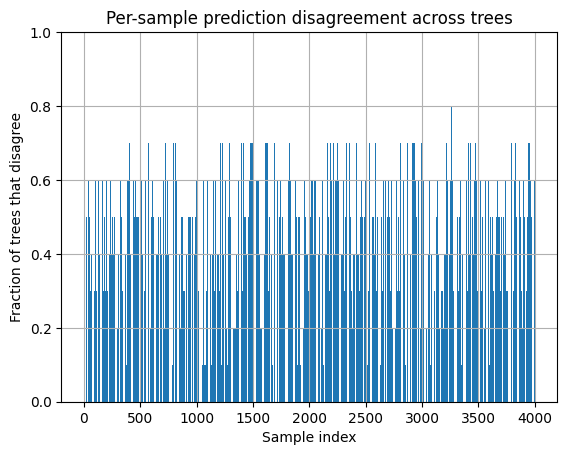

In [8]:
import tqdm 

depth = 15
predictions = []

n_classes = len(class_names)
n_samples = len(X_train)
n_test_sampes = len(X_test)

for _ in tqdm.tqdm(range(10)):

    # Randomly sample 80% of the training data for each run
    indices = np.random.choice(n_samples, size=(n_samples)//5*4)
    X_sample, Y_sample = X_train[indices], X_train[indices]

    model = DecisionTreeClassifier(max_depth=depth, min_samples_split=1)
    model.fit(X_sample, Y_sample)

    # Predict on the test set (not used in training in any run)
    preds = model(X_test)
    predictions.append(preds)

predictions = np.array(predictions)  # shape: (n_runs, n_samples)

def majority_vote(preds):
    #Return the most common prediction
    return np.bincount(preds).argmax()

# Compute majority prediction per sample
majority_preds = np.apply_along_axis(majority_vote, axis=0, arr=predictions)

# Compute fraction of disagreeing trees for each sample
disagreement = np.mean(predictions != majority_preds, axis=0)  # shape: (n_samples,)

plt.bar(range(n_test_sampes), disagreement)
plt.xlabel("Sample index")
plt.ylabel("Fraction of trees that disagree")
plt.title("Per-sample prediction disagreement across trees")
plt.ylim(0, 1)
plt.grid(True)

print(f"Average disagreement across all samples: {np.mean(disagreement):.4f}")

### ⚠️ Limitations of Decision Trees

While decision trees are simple and interpretable, they have several key limitations:

- **Exhaustive splitting**: At each node, the algorithm searches over **all features** and **all possible thresholds** (i.e. unique values), which becomes slow for large or high-dimensional datasets.

- **Overfitting**: Deep trees can **perfectly fit training data**, capturing noise rather than general patterns — especially when `max_depth` is large or `min_samples_split` is small.

- **Instability**: Trees are **high-variance models** — small changes in the data can lead to very different splits and tree structures.

- **Axis-aligned splits only**: Each split uses just a **single feature**, so approximating diagonal or curved boundaries requires many steps and can be inefficient.


> 🧠 These weaknesses are addressed by ensemble methods like **Bagging** and **Random Forests**, which combine multiple trees to reduce variance and improve accuracy.
